# APLICACIÓN DEL MODELO DE MACHINE LEARNING

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CARGAR Y PREPROCESAR DATOS

In [3]:
# Cargar datos
df = pd.read_csv('./soja-serie-1941-2023.csv', encoding='utf-8')

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

# Convertir a tipos numéricos
cols_num = ['anio','provincia_id','departamento_id','superficie_sembrada_ha',
            'superficie_cosechada_ha','produccion_tm','rendimiento_kgxha']

for c in cols_num:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# ANÁLISIS INICIAL Y ESTADÍSTICAS DESCRIPTIVAS

In [4]:
print("INFORMACIÓN DEL DATASET ORIGINAL")
df.info()

INFORMACIÓN DEL DATASET ORIGINAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12315 entries, 0 to 12314
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   cultivo_nombre           12315 non-null  object
 1   anio                     12315 non-null  int64 
 2   campania                 12315 non-null  object
 3   provincia_nombre         12315 non-null  object
 4   provincia_id             12315 non-null  int64 
 5   departamento_nombre      12315 non-null  object
 6   departamento_id          12315 non-null  int64 
 7   superficie_sembrada_ha   12315 non-null  int64 
 8   superficie_cosechada_ha  12315 non-null  int64 
 9   produccion_tm            12315 non-null  int64 
 10  rendimiento_kgxha        12315 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1.0+ MB


In [5]:
print("\nESTADÍSTICAS DESCRIPTIVAS")
print(df.describe().T)


ESTADÍSTICAS DESCRIPTIVAS
                           count           mean            std     min  \
anio                     12315.0    1997.465936      17.538316  1941.0   
provincia_id             12315.0      33.771336      30.222514     6.0   
departamento_id          12315.0   33970.578806   30105.604271  6007.0   
superficie_sembrada_ha   12315.0   41067.252781   80890.866663     0.0   
superficie_cosechada_ha  12315.0   39860.312302   79329.907007     0.0   
produccion_tm            12315.0  103229.241981  231429.962928     0.0   
rendimiento_kgxha        12315.0    2006.050670     823.995203     0.0   

                            25%      50%      75%        max  
anio                     1984.0   2000.0   2012.0     2023.0  
provincia_id                6.0     22.0     54.0       90.0  
departamento_id          6651.0  22049.0  54112.0    90119.0  
superficie_sembrada_ha    653.0   7000.0  45050.0   894613.0  
superficie_cosechada_ha   600.0   6300.0  43000.0   883613.0  
pr

#  MANEJO DE OUTLIERS EN RENDIMIENTO

In [6]:
print("\nVALORES FALTANTES POR COLUMNA")
print(df.isnull().sum())


VALORES FALTANTES POR COLUMNA
cultivo_nombre             0
anio                       0
campania                   0
provincia_nombre           0
provincia_id               0
departamento_nombre        0
departamento_id            0
superficie_sembrada_ha     0
superficie_cosechada_ha    0
produccion_tm              0
rendimiento_kgxha          0
dtype: int64


Dataset original: 12315 filas
Dataset sin outliers: 12253 filas
Outliers eliminados: 62 filas


C:\Users\briia\AppData\Local\Temp\ipykernel_10108\1765538892.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='Estado', y='rendimiento_kgxha', palette='viridis')


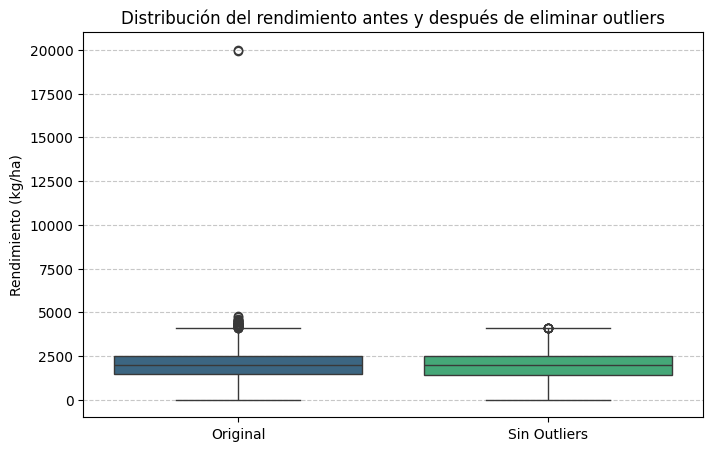

In [7]:
Q1 = df['rendimiento_kgxha'].quantile(0.25)
Q3 = df['rendimiento_kgxha'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

df_sin_outliers = df[(df['rendimiento_kgxha'] >= limite_inf) & 
                     (df['rendimiento_kgxha'] <= limite_sup)]

print(f"Dataset original: {len(df)} filas")
print(f"Dataset sin outliers: {len(df_sin_outliers)} filas")
print(f"Outliers eliminados: {len(df) - len(df_sin_outliers)} filas")

df_box = pd.DataFrame({
    'rendimiento_kgxha': pd.concat([
        df['rendimiento_kgxha'], 
        df_sin_outliers['rendimiento_kgxha']
    ], ignore_index=True),
    'Estado': ['Original'] * len(df) + ['Sin Outliers'] * len(df_sin_outliers)
})

# --- Gráfico de caja ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_box, x='Estado', y='rendimiento_kgxha', palette='viridis')
plt.title('Distribución del rendimiento antes y después de eliminar outliers')
plt.xlabel('')
plt.ylabel('Rendimiento (kg/ha)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ANÁLISIS DE CORRELACIÓN

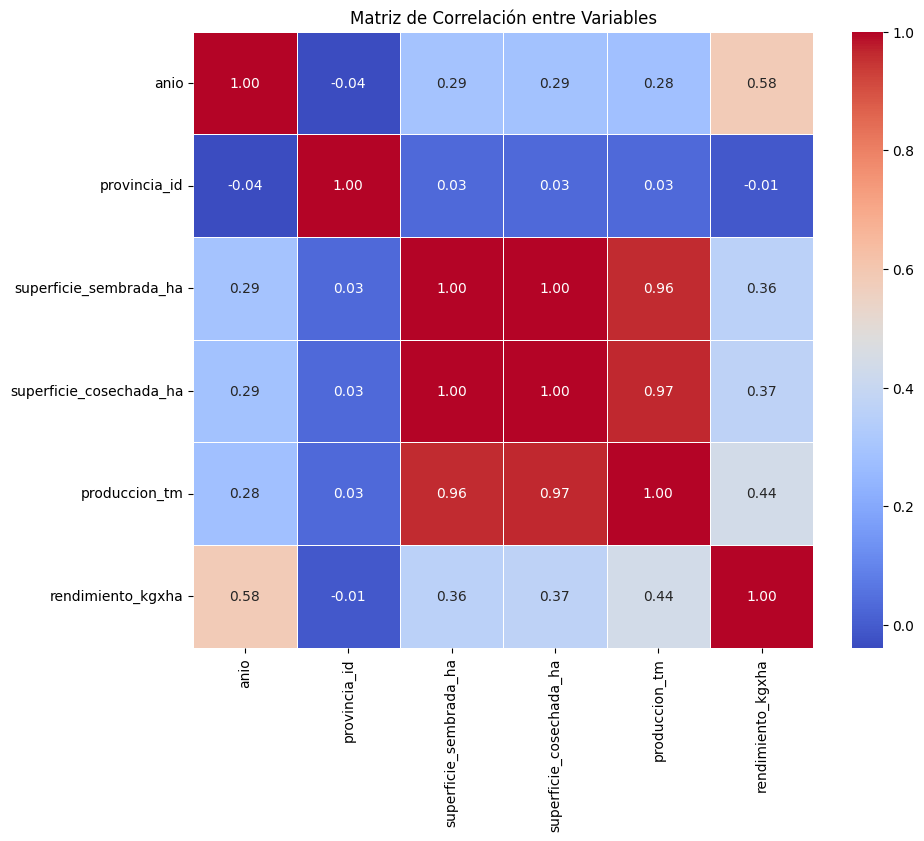

In [8]:
plt.figure(figsize=(10, 8))
cols_corr = ['anio', 'provincia_id', 'superficie_sembrada_ha',
             'superficie_cosechada_ha', 'produccion_tm', 'rendimiento_kgxha']
sns.heatmap(df_sin_outliers[cols_corr].corr(),
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)
plt.title('Matriz de Correlación entre Variables')
plt.show()

# PREPARAR DATOS PARA EL MODELO

In [10]:
# Variables predictoras y objetivo
X = df_sin_outliers[['anio', 'provincia_id', 'superficie_sembrada_ha',
                     'superficie_cosechada_ha', 'produccion_tm']]
y = df_sin_outliers['rendimiento_kgxha']

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_sin_outliers['provincia_id']
)

print(f"\n Datos divididos correctamente:")
print(f"   - Entrenamiento: {X_train.shape}")
print(f"   - Prueba: {X_test.shape}")


 Datos divididos correctamente:
   - Entrenamiento: (9802, 5)
   - Prueba: (2451, 5)


# ENTRENAR MODELO RANDOM FOREST

In [13]:
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

modelo_rf.fit(X_train, y_train)
print("Modelo Random Forest entrenado correctamente")

Modelo Random Forest entrenado correctamente


# EVALUAR EL MODELO

In [16]:
y_pred = modelo_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n MÉTRICAS DE EVALUACIÓN:")
print(f"   - MAE: {mae:.2f} kg/ha")
print(f"   - RMSE: {rmse:.2f} kg/ha")
print(f"   - R²: {r2:.4f}")


 MÉTRICAS DE EVALUACIÓN:
   - MAE: 179.14 kg/ha
   - RMSE: 263.01 kg/ha
   - R²: 0.8834


# IMPORTANCIA DE VARIABLES

In [ ]:
df_importancia = (
    pd.DataFrame({
        'Variable': X.columns,
        'Importancia': modelo_rf.feature_importances_
    })
    .assign(Importancia_Normalizada=lambda d: (d['Importancia'] / d['Importancia'].sum()).round(4))
    .sort_values(by='Importancia', ascending=False)
)

print(f"\n IMPORTANCIA DE VARIABLES:")
for _, row in df_importancia.iterrows():
    print(f"   {row['Variable']}: {row['Importancia_Normalizada']:.4f}")



 IMPORTANCIA DE VARIABLES:
   produccion_tm: 0.4583
   anio: 0.3225
   superficie_sembrada_ha: 0.1377
   superficie_cosechada_ha: 0.0588
   provincia_id: 0.0228


C:\Users\briia\AppData\Local\Temp\ipykernel_10108\864313397.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia, x='Importancia_Normalizada', y='Variable', palette='viridis')


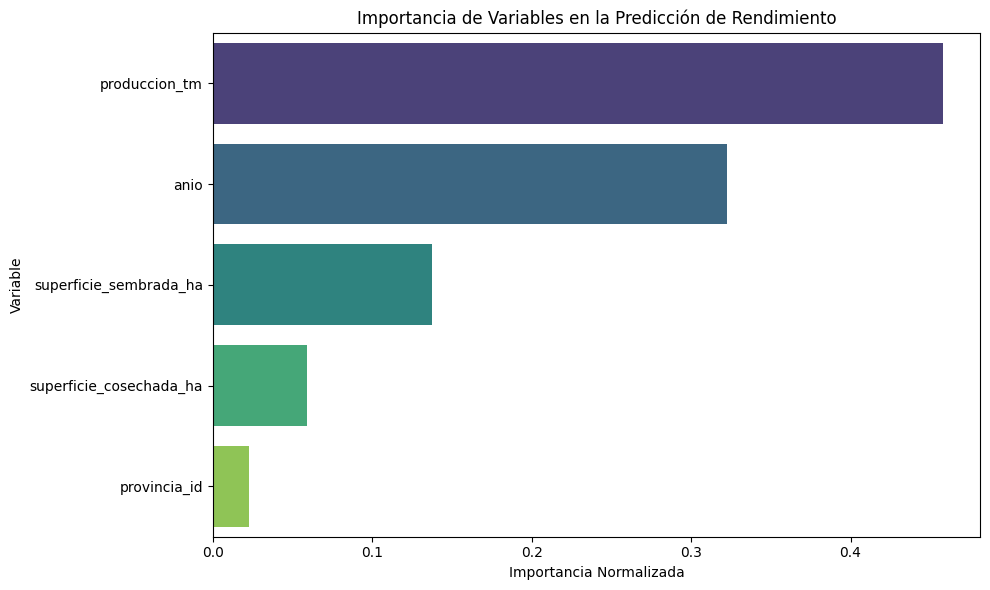

In [19]:
# GRAFICO
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancia, x='Importancia_Normalizada', y='Variable', palette='viridis')
plt.title('Importancia de Variables en la Predicción de Rendimiento')
plt.xlabel('Importancia Normalizada')
plt.tight_layout()
plt.show()

# VISUALIZACIÓN DE RESULTADOS

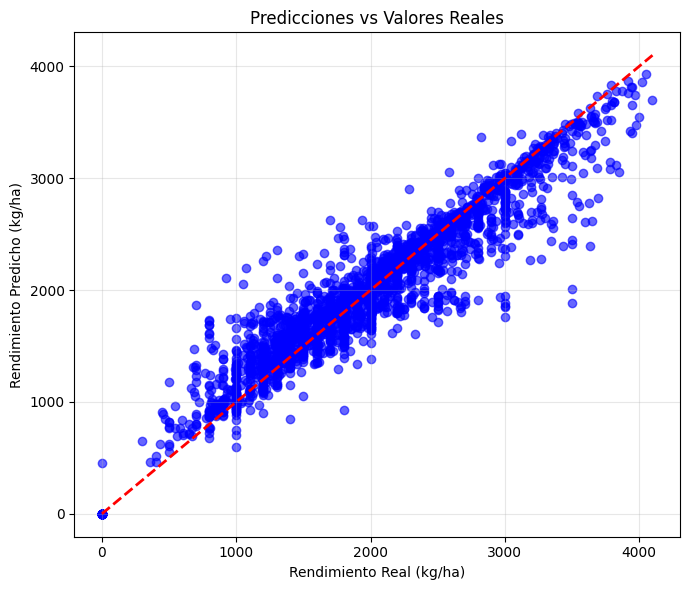

In [21]:
# --- Predicciones vs Valores Reales ---
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Rendimiento Real (kg/ha)')
plt.ylabel('Rendimiento Predicho (kg/ha)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


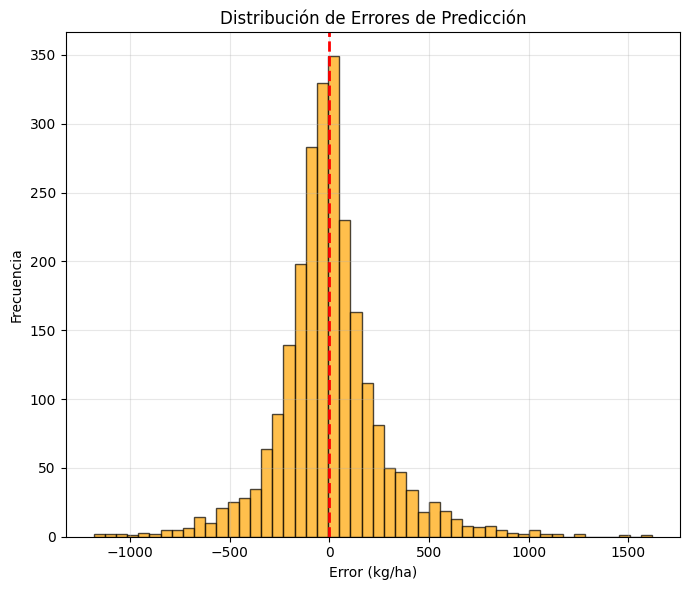

In [22]:
# --- Distribución de Errores ---
errores = y_test - y_pred
plt.figure(figsize=(7, 6))
plt.hist(errores, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Distribución de Errores de Predicción')
plt.xlabel('Error (kg/ha)')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

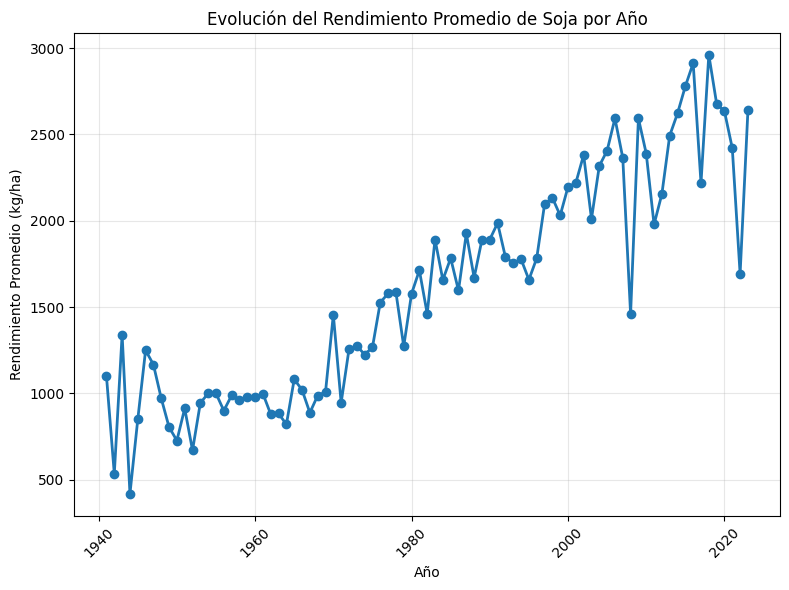

In [ ]:
# --- Evolución del Rendimiento Promedio por Año ---
plt.figure(figsize=(8, 6))
rendimiento_anual = df_sin_outliers.groupby('anio')['rendimiento_kgxha'].mean()
plt.plot(rendimiento_anual.index, rendimiento_anual.values, marker='o', linewidth=2)
plt.title('Evolución del Rendimiento Promedio de Soja por Año')
plt.xlabel('Año')
plt.ylabel('Rendimiento Promedio (kg/ha)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\briia\AppData\Local\Temp\ipykernel_10108\2843966182.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_prov, x='rendimiento_kgxha', y='provincia_nombre', palette='viridis')


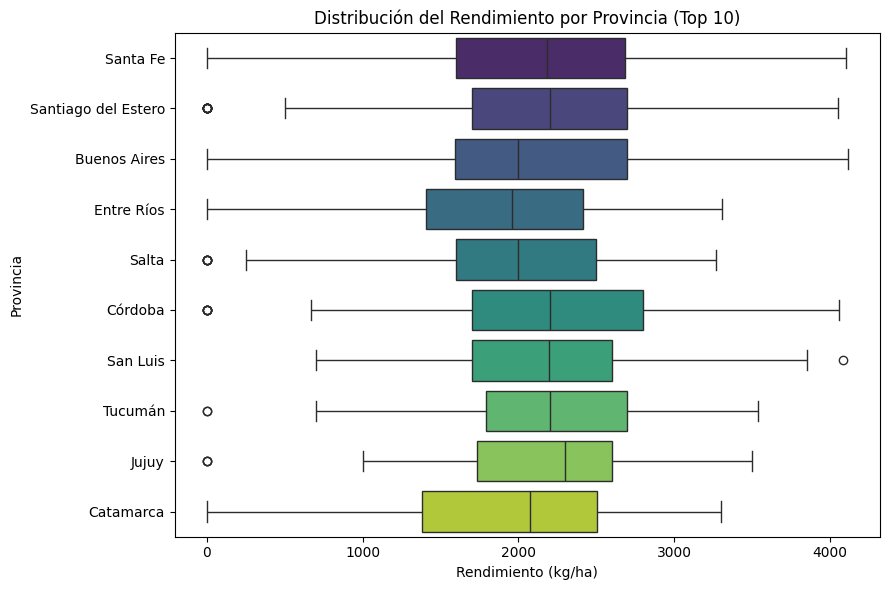

In [25]:
# --- Boxplot del Rendimiento por Provincia (Top 10) ---
plt.figure(figsize=(9, 6))
top_provincias = (
    df_sin_outliers.groupby('provincia_nombre')['rendimiento_kgxha']
    .mean().nlargest(10).index
)
df_top_prov = df_sin_outliers[df_sin_outliers['provincia_nombre'].isin(top_provincias)]
sns.boxplot(data=df_top_prov, x='rendimiento_kgxha', y='provincia_nombre', palette='viridis')
plt.title('Distribución del Rendimiento por Provincia (Top 10)')
plt.xlabel('Rendimiento (kg/ha)')
plt.ylabel('Provincia')
plt.tight_layout()
plt.show()

# GUARDAR RESULTADOS

In [26]:
df_resultados = X_test.assign(
    Rendimiento_Real_kgxha=y_test.values,
    Rendimiento_Predicho_kgxha=y_pred.round(2),
    Error_Absoluto_kgxha=np.abs(y_test.values - y_pred).round(2),
    Error_Relativo_pct=(np.abs(y_test.values - y_pred) / y_test.values * 100).round(2),
    Provincia_Nombre=lambda d: d['provincia_id'].map(
        df_sin_outliers[['provincia_id', 'provincia_nombre']].drop_duplicates().set_index('provincia_id')['provincia_nombre']
    )
)

df_resultados.to_csv('resultados_prediccion_rendimiento_soja.csv', index=False, encoding='utf-8')
df_importancia.to_csv('importancia_variables_rendimiento_soja.csv', index=False, encoding='utf-8')

print("\n Archivos guardados:")
print("   - resultados_prediccion_rendimiento_soja.csv")
print("   - importancia_variables_rendimiento_soja.csv")

C:\Users\briia\AppData\Local\Temp\ipykernel_10108\1526207571.py:5: RuntimeWarning: divide by zero encountered in divide
  Error_Relativo_pct=(np.abs(y_test.values - y_pred) / y_test.values * 100).round(2),
C:\Users\briia\AppData\Local\Temp\ipykernel_10108\1526207571.py:5: RuntimeWarning: invalid value encountered in divide
  Error_Relativo_pct=(np.abs(y_test.values - y_pred) / y_test.values * 100).round(2),



 Archivos guardados:
   - resultados_prediccion_rendimiento_soja.csv
   - importancia_variables_rendimiento_soja.csv


# FUNCIÓN PARA PREDICCIONES NUEVAS

In [27]:
def predecir_rendimiento(anio, provincia_id, superficie_sembrada, superficie_cosechada, produccion):
    """
    Función para predecir rendimiento con nuevos datos
    
    Parámetros:
    - anio: año de la campaña
    - provincia_id: ID de la provincia
    - superficie_sembrada: superficie sembrada en hectáreas
    - superficie_cosechada: superficie cosechada en hectáreas  
    - produccion: producción total en toneladas métricas
    
    Retorna:
    - rendimiento_predicho: rendimiento predicho en kg/ha
    """
    
    # Crear array con los datos de entrada
    datos_entrada = np.array([[anio, provincia_id, superficie_sembrada, 
                             superficie_cosechada, produccion]])
    
    # Realizar predicción
    rendimiento_predicho = modelo_rf.predict(datos_entrada)[0]
    
    return rendimiento_predicho

In [28]:
# Ejemplo de uso
print(f"\n EJEMPLO DE PREDICCIÓN:")
ejemplo_prediccion = predecir_rendimiento(
    anio=2024,
    provincia_id=6,  # Buenos Aires
    superficie_sembrada=50000,
    superficie_cosechada=48000,
    produccion=120000
)
print(f"   Rendimiento predicho para 2024: {ejemplo_prediccion:.2f} kg/ha")


 EJEMPLO DE PREDICCIÓN:


c:\Users\briia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Rendimiento predicho para 2024: 2540.33 kg/ha


# ANÁLISIS DE RESIDUOS

In [31]:
print(f"\n ANÁLISIS DE RESIDUOS:")
print(f"   - Media de errores: {errores.mean():.2f} kg/ha")
print(f"   - Desviación estándar de errores: {errores.std():.2f} kg/ha")
print(f"   - Porcentaje de predicciones con error < 100 kg/ha: {(np.abs(errores) < 100).mean()*100:.1f}%")
print(f"   - Porcentaje de predicciones con error < 200 kg/ha: {(np.abs(errores) < 200).mean()*100:.1f}%")


 ANÁLISIS DE RESIDUOS:
   - Media de errores: -3.01 kg/ha
   - Desviación estándar de errores: 263.05 kg/ha
   - Porcentaje de predicciones con error < 100 kg/ha: 44.2%
   - Porcentaje de predicciones con error < 200 kg/ha: 68.7%
